# Exploratory Analysis of a Monthly Dataset

In [8]:
# do the below to load the python utilities from py_depends

In [9]:
cd ..

/Users/svyatnakonechny


In [102]:
import os
from py_depends.utils import *
from aux.dtypes import *

# visualizations and such
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

# sanity check - assert the import worked correctly
try:
    assert 'flight-delays' in os.getcwd()
except AssertionError:
    print('Doesn\'t look like the cd .. hack worked - restart the kernel and try again')

Doesn't look like the cd .. hack worked - restart the kernel and try again


_First, some housekeeping. Reading in a sample file,_

In [11]:
%time jan_2018_df = unzipFile('./sample_data/On_Time_Marketing_Carrier_On_Time_Performance_Beginning_January_2018_2018_1.zip')
# and assigning correct(?) types
%time subs_jan_2018_df = subsetRenameRetype(jan_2018_df, new_cols)
# and finally shaping those date-time columns - this is a massive bottleneck because it loops through the entire dataframe _for each column pair_. Incredibly inefficient
%time subs_jan_2018_df = shapeDatetime(subs_jan_2018_df, ['crs_dep_time', 'dep_time','crs_arr_time', 'arr_time', 'first_dep_time', 'diverted_wheels_off_1', 'diverted_wheels_off_2', 'diverted_wheels_off_3'], 'flight_date')

FileNotFoundError: [Errno 2] No such file or directory: './sample_data/On_Time_Marketing_Carrier_On_Time_Performance_Beginning_January_2018_2018_1.zip'

CPU times: user 3.85 s, sys: 467 ms, total: 4.31 s
Wall time: 4.32 s
Shaping crs_dep_time-flight_date columns
Shaping dep_time-flight_date columns
Shaping crs_arr_time-flight_date columns
Shaping arr_time-flight_date columns
Shaping first_dep_time-flight_date columns
Shaping diverted_wheels_off_1-flight_date columns
Shaping diverted_wheels_off_2-flight_date columns
Shaping diverted_wheels_off_3-flight_date columns
CPU times: user 3min 28s, sys: 5.93 s, total: 3min 34s
Wall time: 3min 36s


## Descriptive stats

### Airports

In [150]:
departure_delay_stats = subs_jan_2018_df.groupby('origin')['dep_delay'].agg(['count', 'mean']).reset_index()
late_departures_only = subs_jan_2018_df[subs_jan_2018_df.dep_delay > 0]
counts_late_departure = late_departures_only.groupby('origin')['origin'].agg(['count']).reset_index()
departure_delay_stats.columns = ['origin', 'total_flights', 'mean_delay']
counts_late_departure.columns = ['origin', 'delayed_flights']
departure_delay_stats = pd.merge(departure_delay_stats, counts_late_departure, how='left')
departure_delay_stats['percentage_departed_late'] = departure_delay_stats['delayed_flights']/departure_delay_stats['total_flights'] * 100
departure_delay_stats = departure_delay_stats.round(3)
departure_delay_stats_sorted = departure_delay_stats.sort_values(by='total_flights', ascending=False)
# stashing 15 busiest airports by total flights for alter
fifteen_busiest_airports = departure_delay_stats_sorted.origin[:15].tolist()
departure_delay_stats_sorted.head(15)

,origin,total_flights,mean_delay,delayed_flights,percentage_departed_late
20,ATL,29836,11.859,11016.0,36.922
241,ORD,29270,15.037,11072.0,37.827
88,DFW,21962,6.920,6738.0,30.680
87,DEN,20247,9.555,6841.0,33.788
184,LAX,20110,5.865,5779.0,28.737
69,CLT,18782,8.731,6553.0,34.890
255,PHX,14597,8.285,5838.0,39.995
303,SFO,14447,7.746,4388.0,30.373
301,SEA,14127,2.275,3451.0,24.428
94,DTW,13565,14.429,4655.0,34.316


Top 15 airports by departures - no massive surprises. Lots of departures from Atlanta, Chicago O'Hare, and the likes, with mean delays between 5 and 15 mins. Looks like the busier an airport is the more likely it is to experiece departure delays (and then there's NYC airports).

_(NTS: make the delays stats dataframe an interactive object)_

Visualizing the distrubtion of delays:

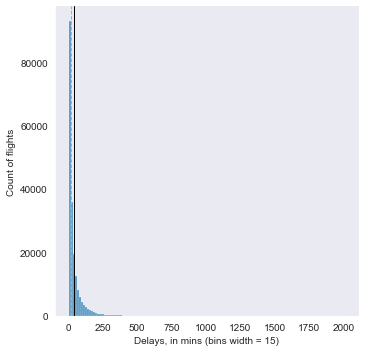

In [119]:
# lifting some SO code to get mean/median working
def specs(x, **kwargs):
    plt.axvline(x.mean(), c='k', ls='-', lw=1, label='Mean')
    plt.axvline(x.median(), c='orange', ls='--', lw=1, label='Median')
    plt.legend(loc='upper left')

delays_distro = sns.displot(late_departures_only, x='dep_delay', binwidth=15)
delays_distro.map(specs,'dep_delay')
delays_distro.set_axis_labels('Delays, in mins (bins width = 15)', 'Count of flights')


_Most delayed flights were delayed for 15 mins or less, with a tail of longer departure delays as well. That plot isn't particularly useful though - it might be nice to see what this distribution looks like per airport, per day, limited to top 15 origin airports by flight count._

<AxesSubplot:xlabel='flight_date', ylabel='origin'>

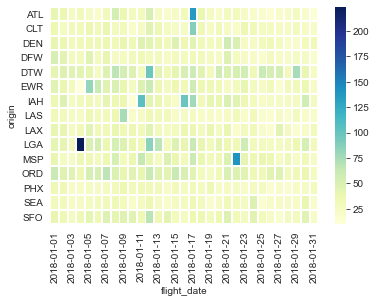

In [191]:
late_departures_only_busiest_15 = late_departures_only[late_departures_only.origin.isin(fifteen_busiest_airports)]
heatmap_date_airport = late_departures_only_busiest_15.groupby(by=[late_departures_only_busiest_15['flight_date'].dt.date, late_departures_only_busiest_15['origin']])['dep_delay'].mean().reset_index()
heatmap_date_airport.flight_date = heatmap_date_airport.flight_date.astype(str)

heatmap_date_airport = heatmap_date_airport.pivot('origin', 'flight_date', 'dep_delay')

# and the visualization now
delays_heatmap = sns.heatmap(heatmap_date_airport, cmap='YlGnBu', linewidths=.8)
delays_heatmap

_What jumps out right away are the horizontal and vertical patterns: seems like Detriot-DTW and Chicago-ORD just had a bad month of January (weather?), and 17 Jan saw system-wide delays (notice the darker colors on that vertical). This latter part might be worth modeling down the line._

_Finally, let's take a look at how departure delays propagate throughout the day of flying and the system at large._

_This breaks down to:_

    1. for a given airplane, if their first flight of the day was delayed, at what point did this delay "wear off" (when did it start showing up on time)?

    2. for a given airport with long departure delays, how did these delays impact the destination airports and the system at large?

### Flights, airplanes, system at large